#### Import Packages

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from utils import generate_data, remove_2d_outlier
from dataset import MyDataset, MyDataset_outlier
from model import MLP
import torch.optim as optim
import argparse
import random
import matplotlib as mpl

import pandas as pd
import seaborn as sns

from IPython.display import display, clear_output
from matplotlib.lines import Line2D  


#### Private Dataset Generation

/home/csxpeng/anaconda3/envs/mia/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


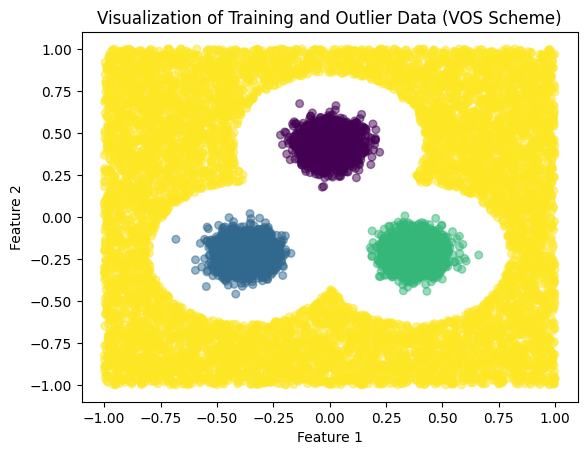

In [2]:
train_scheme = "vos"
save_path = f'./results/{train_scheme}.pth' 
gap = 12 
variance = 1.0
data_num = 3000
class_num =3 
input_dim = 2
positive_limit = 16

train_data_num  =  [data_num for _ in range(class_num)] 
batch_size = sum(train_data_num) 

gap_list = [0, - gap/2, gap/2 ]
y_center = [gap /np.sqrt(3), - gap /np.sqrt(3)/2, - gap /np.sqrt(3)/2]


train_data, train_label = generate_data(batch_size,input_dim, class_num, gap_list,y_center, variance, train_data_num )
train_data_normal = train_data / positive_limit
if train_scheme == 'vos':
    outlier = np.random.random((class_num* data_num,2)) * 2 * positive_limit  - positive_limit
    p_outlier = 0.000000000005   
    outlier = remove_2d_outlier(outlier, p_outlier, gap_list ,y_center , [variance for _ in range(class_num)], positive_limit)
    outlier_label = torch.cat((torch.ones(len(outlier)), torch.zeros(len(outlier))), 0)
    outlier_label = torch.unsqueeze(outlier_label, 1).float() 
    outlier_train_data = (torch.from_numpy(outlier)).float()
    outlier_train_data = outlier_train_data / positive_limit
    outlier_dataset = MyDataset(outlier_train_data, outlier_label[len(outlier_label)//2:,:])
    outlier_train_loader = DataLoader(outlier_dataset, batch_size=batch_size,shuffle=True)
    outlier_criterion = torch.nn.BCELoss(size_average=True)
    
    dataset = MyDataset_outlier(train_data_normal, train_label, outlier_label[:len(outlier_label)//2,:])
    train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

    all_inputs = []
    all_labels = []

    for data in train_loader:
        inputs, labels = data[0], data[1]
        all_inputs.append(inputs.numpy())
        all_labels.append(labels.numpy())

    all_inputs = np.concatenate(all_inputs)
    all_labels = np.concatenate(all_labels)

    all_outlier_inputs = []
    all_outlier_labels = []

    for data in outlier_train_loader:
        outlier_inputs, _ = data[0], data[1]  
        all_outlier_inputs.append(outlier_inputs.numpy())
        all_outlier_labels.append(np.full(outlier_inputs.shape[0], fill_value=np.max(all_labels)+1))

    all_outlier_inputs = np.concatenate(all_outlier_inputs)
    all_outlier_labels = np.concatenate(all_outlier_labels)

    final_inputs = np.vstack((all_inputs, all_outlier_inputs))
    final_labels = np.concatenate((all_labels, all_outlier_labels))

    scatter_size = 30
    plt.scatter(final_inputs[:, 0], final_inputs[:, 1], c=final_labels, cmap='viridis', s=scatter_size, marker="o", alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Visualization of Training and Outlier Data (VOS Scheme)')
    plt.savefig(f'results/dataset_{train_scheme}.png',  dpi=200, bbox_inches='tight')
    plt.show()


else:
    dataset = MyDataset(train_data_normal, train_label)
    train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

    all_inputs = []
    all_labels = []
    for data in train_loader:
        inputs, labels = data[0], data[1]
        all_inputs.append(inputs.numpy())
        all_labels.append(labels.numpy())
    
    all_inputs = np.concatenate(all_inputs)
    all_labels = np.concatenate(all_labels)
    
    scatter_size = 30
    plt.scatter(all_inputs[:, 0], all_inputs[:, 1], c=all_labels, cmap='viridis',s=scatter_size, marker="o", alpha=0.5)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Visualization of All Training Data (CE Scheme)')
    plt.savefig(f'results/dataset_{train_scheme}.png',  dpi=200, bbox_inches='tight')
    plt.show()




### Train Target Classifier with Private Data

In [3]:
eval_model = True
warmup_num=20
learning_rate =  0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = torch.nn.Sigmoid()


model_vanilia = MLP(input_dim, class_num)
save_path = f'./results/{train_scheme}.pth' 

if eval_model:
    model_vanilia.load_state_dict(torch.load(save_path))
    model_vanilia.to(device)
else:
    if train_scheme == 'vos':
        optimizer_vanilia = optim.SGD(model_vanilia.parameters() ,lr=learning_rate,weight_decay=0)
        train_epoch = 6000
    else:
        optimizer_vanilia = optim.SGD(model_vanilia.parameters(),lr=learning_rate,weight_decay=0.0005) 
        train_epoch = 3000

    loss_function = nn.CrossEntropyLoss()
    model_vanilia.to(device)

    lambda_va = lambda epoch: (0.9*epoch / warmup_num +0.1) if epoch < warmup_num else 1 
    scheduler_vanilia = optim.lr_scheduler.LambdaLR(optimizer_vanilia, lr_lambda=lambda_va)

    for epoch in range(train_epoch): 

        if train_scheme == 'vos':
            for step, data in enumerate(zip(train_loader, outlier_train_loader), start=0):  
                inputs, labels, in_outlier_labels = data[0][0],  data[0][1],  data[0][2]	
                outlier_inputs, outlier_labels = data[1][0],  data[1][1]
                optimizer_vanilia.zero_grad()  

                data_cat = torch.cat((inputs, outlier_inputs), 0)
                label_cat =  torch.cat((in_outlier_labels, outlier_labels* 0), 0)
                outputs_vanilia = model_vanilia(data_cat.to(device))
                outlier_energy = torch.logsumexp(outputs_vanilia, dim=1, keepdim=True)  
                pred_outlier = sigmoid(outlier_energy)
                loss_vanilia = loss_function(outputs_vanilia[:len(outputs_vanilia)//2], labels.to(device)) 
                loss_ood = outlier_criterion(pred_outlier, label_cat.to(device))
                loss = loss_vanilia +  0.1 * loss_ood
                loss.backward()
                optimizer_vanilia.step() 	

        else:
            
            for data in train_loader:  
                inputs, labels = data[0],  data[1]
                optimizer_vanilia.zero_grad()  
                outputs_vanilia = model_vanilia(inputs.to(device))
                loss = loss_function(outputs_vanilia, labels.to(device)) 
                loss.backward() 				
                optimizer_vanilia.step() 	

        with torch.no_grad():
            if (epoch+1)%50==0:
                torch.save(model_vanilia.state_dict(), save_path)  
                with torch.no_grad():
                    if train_scheme == 'vos':
                        pred_outlier = torch.sign(pred_outlier - 1/2)
                        pred_outlier = (pred_outlier + 1)/2
                        outlier_accuracy = (pred_outlier == label_cat.to(device)).sum().item() / label_cat.size(0) 
                        print(epoch+1, 'loss_OOD:', loss_ood.item(),'loss_ce:', loss_vanilia.item(), 'OOD test acc:', outlier_accuracy)
                    else:
                        print(epoch+1, 'loss_ce:', loss.item())
        scheduler_vanilia.step()
    print('Finished Training')
    torch.save(model_vanilia.state_dict(), save_path)


50 loss_OOD: 0.7450463175773621 loss_ce: 0.019068988040089607 OOD test acc: 0.6391111111111111
100 loss_OOD: 0.625401496887207 loss_ce: 0.005654101260006428 OOD test acc: 0.674
150 loss_OOD: 0.5389142036437988 loss_ce: 0.0030794457998126745 OOD test acc: 0.7739444444444444
200 loss_OOD: 0.4621661305427551 loss_ce: 0.001996938604861498 OOD test acc: 0.8459444444444445
250 loss_OOD: 0.3937789797782898 loss_ce: 0.0014035821659490466 OOD test acc: 0.89
300 loss_OOD: 0.333154559135437 loss_ce: 0.0010359417647123337 OOD test acc: 0.9196111111111112
350 loss_OOD: 0.2799292504787445 loss_ce: 0.0007942167576402426 OOD test acc: 0.9428333333333333
400 loss_OOD: 0.2335948944091797 loss_ce: 0.0006308910087682307 OOD test acc: 0.9605555555555556
450 loss_OOD: 0.1953943967819214 loss_ce: 0.0005059059476479888 OOD test acc: 0.9742222222222222
500 loss_OOD: 0.16439014673233032 loss_ce: 0.00040715307113714516 OOD test acc: 0.9825
550 loss_OOD: 0.1396150439977646 loss_ce: 0.00032816416933201253 OOD test

### Energy Distribution

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


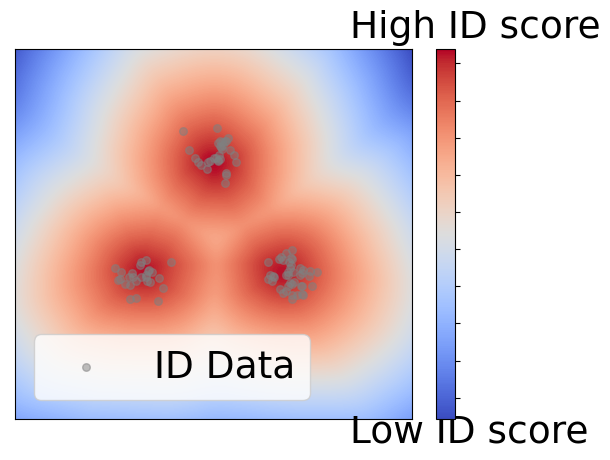

In [4]:
plot_num = 50
range_num = 16
x = np.linspace(-range_num, range_num, range_num * plot_num)
y = np.linspace(-range_num, range_num, range_num * plot_num)
z = np.zeros (( range_num * plot_num,  range_num * plot_num))

x = np.expand_dims(x, axis=1)

x =x.repeat(range_num * plot_num, axis = 1)  
y = x.T
x_test = np.expand_dims(np.asarray(x).reshape(-1), 1) 
y_test = np.expand_dims(np.asarray(y).reshape(-1), 1) 
test_data_demo = np.concatenate((x_test, y_test), 1)
test_data_demo = torch.from_numpy(test_data_demo).float()
outputs_test = model_vanilia((test_data_demo/positive_limit).to(device)) 					
outputs_test = outputs_test.cpu().detach().numpy()

MSP_base = np.sum( np.exp(outputs_test), axis=1)
MSP_base = np.reshape(MSP_base, (-1, len(x)))
Energy_test_vanilia =  - np.log (MSP_base)

scatter_size = 30
alpha_value = 0.1
height_location = 11
font_size= 27 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.contourf(x,  y, - Energy_test_vanilia, 500  , cmap=mpl.colormaps['coolwarm'], linestyles = 'dashed')
cb = plt.colorbar()
plt.setp(cb.ax.get_yticklabels(), visible=False)
plt.text(height_location, 17, 'High ID score',  fontdict={'family' : 'Times New Roman', 'size'   : font_size}) 
plt.text(height_location, -18, 'Low ID score',  fontdict={'family' : 'Times New Roman', 'size'   : font_size}) 
plt.xticks([])
plt.yticks([])
points_visual = 100
points_visual_index = random.sample(range(0, train_data.size(0)), points_visual) 
plt.scatter(train_data[points_visual_index,0],train_data[points_visual_index,1], s=scatter_size, marker="o", alpha=0.5, c = 'grey' , label='ID Data') 
plt.rc('font',family='Times New Roman')
plt.legend(scatterpoints=1,fontsize=font_size)  
plt.savefig(f'results/contour_{train_scheme}.png',  dpi=200, bbox_inches='tight')

### Prepare Public Dataset

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


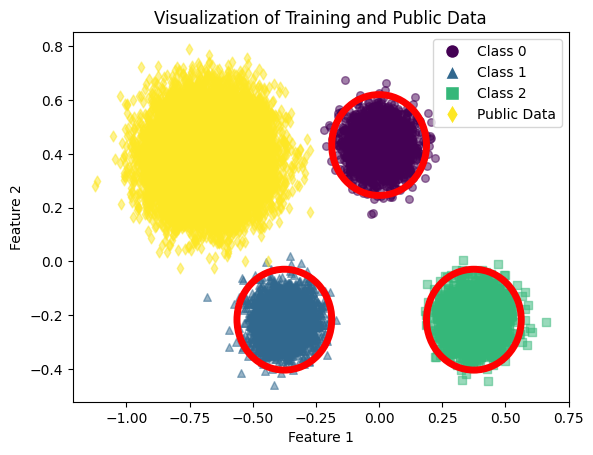

In [6]:
public_variance = 3

public_data_num  =  [2 *data_num * class_num] 
public_batch_size = sum(public_data_num) 

public_gap_list = [- gap*0.9]
public_y_center = [gap*0.9 /np.sqrt(3)]

public_data, public_label = generate_data(public_batch_size, input_dim, 1, public_gap_list, public_y_center, public_variance, public_data_num)
public_data_normal = public_data / positive_limit

dataset = MyDataset(public_data_normal, public_label)
public_data_loader = DataLoader(dataset, batch_size=public_batch_size, shuffle=True)

all_inputs = []
all_labels = []

for data in train_loader:
    inputs, labels = data[0], data[1]
    all_inputs.append(inputs.numpy())
    all_labels.append(labels.numpy())

all_inputs = np.concatenate(all_inputs)
all_labels = np.concatenate(all_labels)

all_public_inputs = []
all_public_labels = []

for data in public_data_loader:
    public_inputs, _ = data[0], data[1]  
    all_public_inputs.append(public_inputs.numpy())
    all_public_labels.append(np.full(public_inputs.shape[0], fill_value=np.max(all_labels)+1))

all_public_inputs = np.concatenate(all_public_inputs)
all_public_labels = np.concatenate(all_public_labels)

final_inputs = np.vstack((all_inputs, all_public_inputs))
final_labels = np.concatenate((all_labels, all_public_labels))

unique_labels = np.unique(final_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

markers = ['o', '^', 's', 'p', '*', 'x', '+', 'd']  

for i, label in enumerate(unique_labels[:-1]):  
    idx = final_labels == label
    plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[i]], label=f'Class {label}', marker=markers[i % len(markers)], s=scatter_size, alpha=0.5)

idx = final_labels == unique_labels[-1]
plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[-1]], label='Public Data', marker=markers[-1], s=scatter_size, alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Training and Public Data')

legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='w', label=f'Class {i}', markerfacecolor=colors[i], markersize=10) for i in range(len(unique_labels)-1)]
legend_elements.append(Line2D([0], [0], marker=markers[-1], color='w', label='Public Data', markerfacecolor=colors[-1], markersize=10))
plt.legend(handles=legend_elements, loc='best')

from matplotlib.patches import Circle
sigma = np.sqrt(variance)
for i in range(class_num):
    circle = Circle((gap_list[i] / positive_limit, y_center[i] / positive_limit), 3 * sigma / positive_limit, color='red', fill=False, linewidth=5)
    plt.gca().add_patch(circle)

plt.savefig(f'results/dataset_{train_scheme}.png', dpi=200, bbox_inches='tight')
plt.show()





### Define the GAN

In [7]:
class Generator(nn.Module):
    def __init__(self, data_dim, hidden_dim, z_dim):
        super().__init__()

        self.MLP = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, data_dim),
        )

        self.apply(weights_init)

    def forward(self, z):
        return self.MLP(z)



class Discriminator(nn.Module):
    def __init__(self, data_dim, hidden_dim):
        super().__init__()

        self.MLP = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 1),
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.MLP(x).view(-1)


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)


class WGAN_GP(nn.Module):
    def __init__(self, data_dim=2, hidden_dim=400, z_dim=2, lambda_gp=10, device="cuda"):
        super().__init__()
        self.__dict__.update(locals())

        self.G = Generator(data_dim, hidden_dim, z_dim)
        self.D = Discriminator(data_dim, hidden_dim)

    def calculate_D_loss(self, z, real_data):
        """ Calculate D loss """
        fake_data = self.G(z).detach()  
        fake_data_score = self.D(fake_data)
        real_data_score = self.D(real_data)
        D_loss = torch.mean(fake_data_score) - torch.mean(real_data_score) + self.lambda_gp * self.gradient_penalty(real_data, fake_data)
        return D_loss

    def calculate_G_loss(self, z):
        """ Calculate G loss """
        fake_data = self.G(z)
        fake_data_score = self.D(fake_data)
        G_loss = -torch.mean(fake_data_score)
        return G_loss

    def evaluate(self, valid_dataloader):
        valid_G_loss, valid_D_loss = [], []
        for batch_data in valid_dataloader:
            real_data = batch_data.to(self.device)
            z = torch.randn(len(batch_data), self.z_dim, device=self.device)
            batch_D_loss = self.calculate_D_loss(z, real_data)
            batch_G_loss = self.calculate_G_loss(z)

            valid_G_loss.append(batch_G_loss.item())
            valid_D_loss.append(batch_D_loss.item())

        return valid_G_loss, valid_D_loss

    def gradient_penalty(self, real_data, fake_data):
        """Calculates the gradient penalty loss for WGAN GP"""
        alpha = torch.rand(len(real_data), 1).to(self.device)
        alpha = alpha.expand_as(real_data)
        interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
        d_interpolates = self.D(interpolates)

        gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones_like(d_interpolates),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(len(real_data), -1)
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()
        return gradient_penalty

    def get_optimizer(self, lr, b1, b2):
        optimizer_G = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(b1, b2))
        optimizer_D = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(b1, b2))
        return optimizer_G, optimizer_D



In [8]:
class WGAN_GP_Config(object):
    data_dim = 2
    hidden_dim = 400
    z_dim = 10

    batch_size = public_batch_size
    lr = 0.0002 
    b1 = 0.5
    b2 = 0.999
    lambda_gp = 10

    max_epoch = 1000
    verbose = 200


### Train the GAN with Public Data 

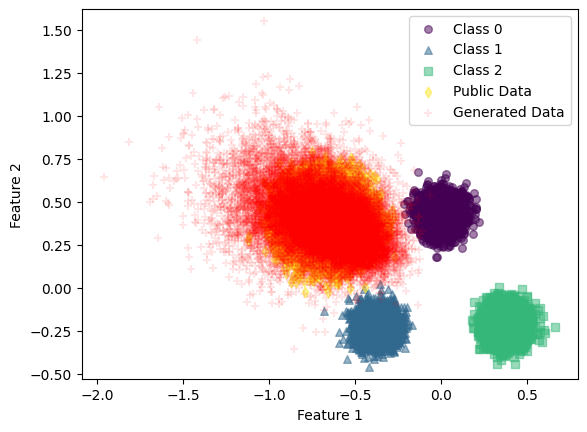

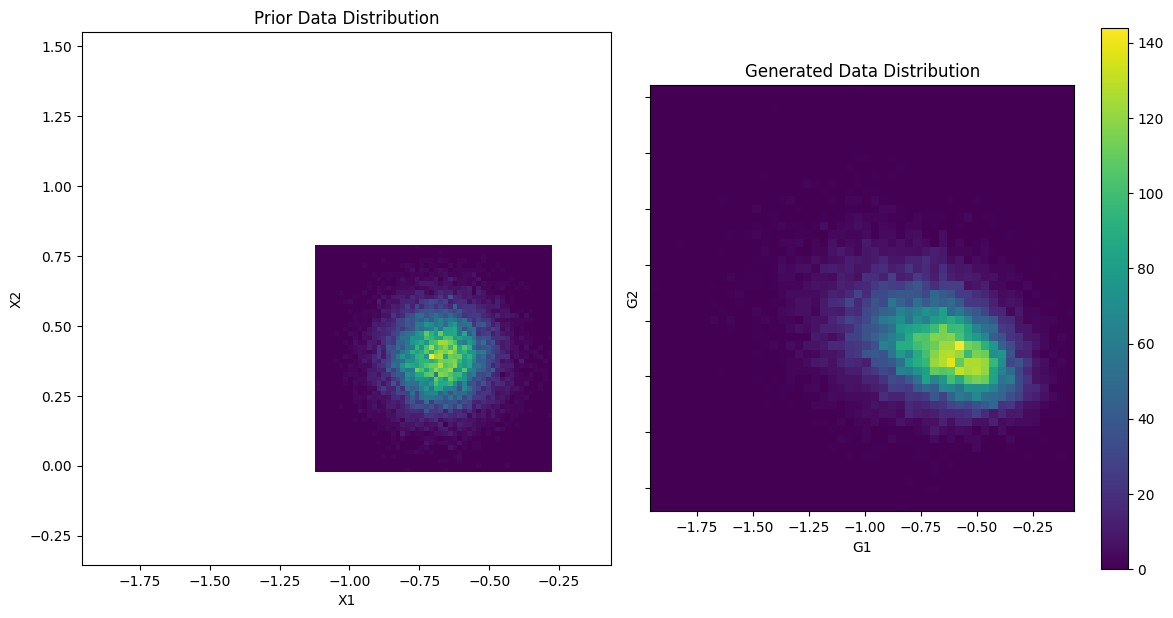

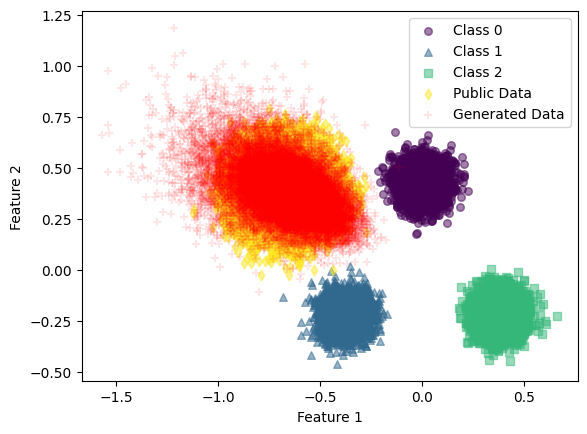

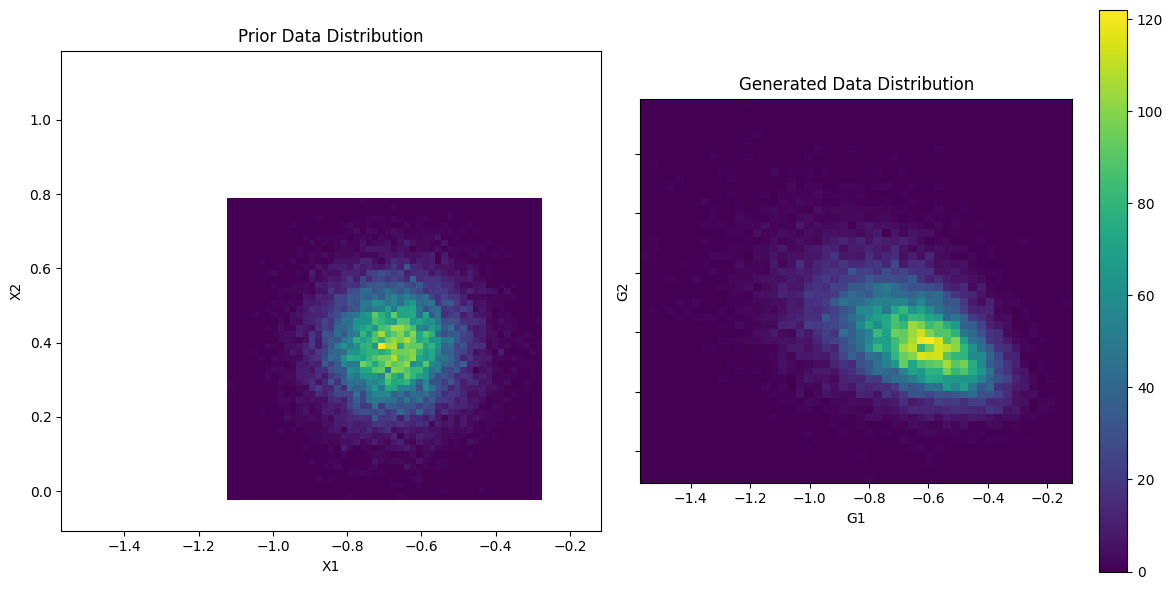

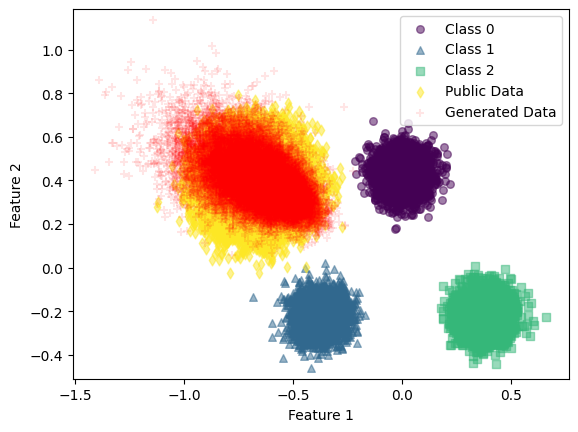

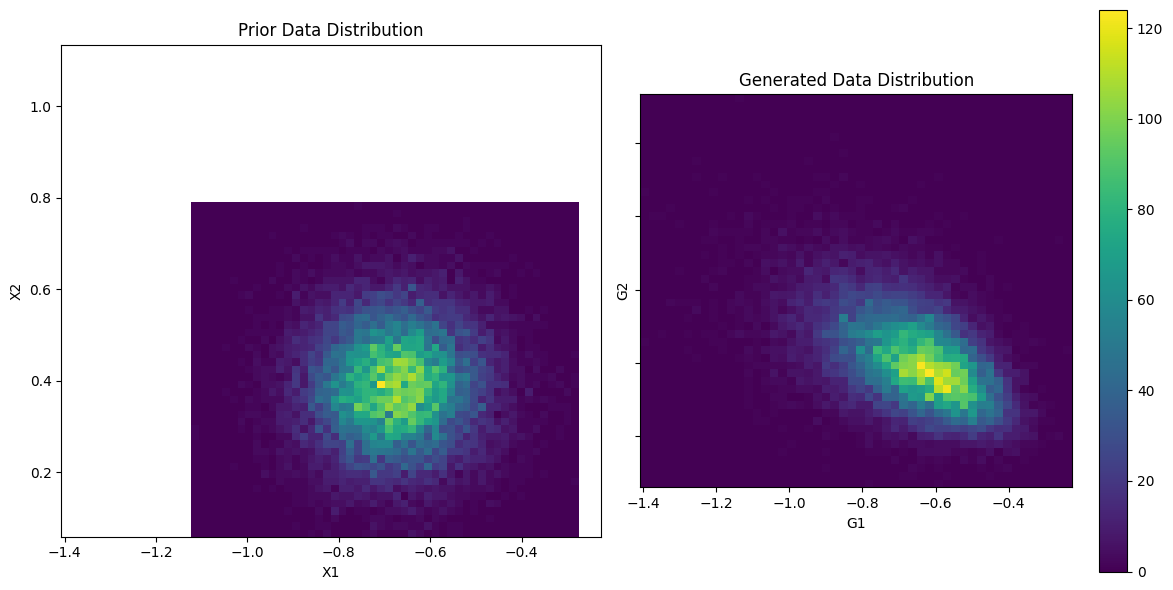

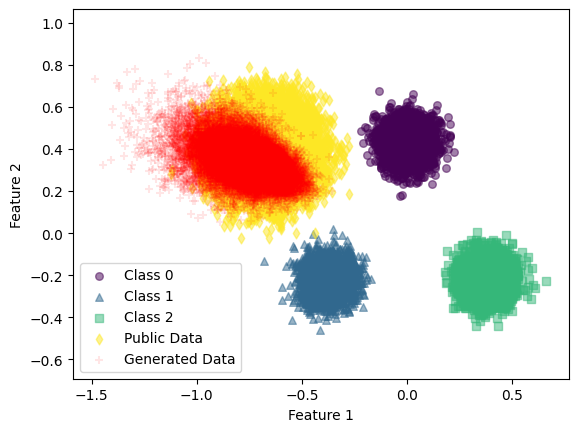

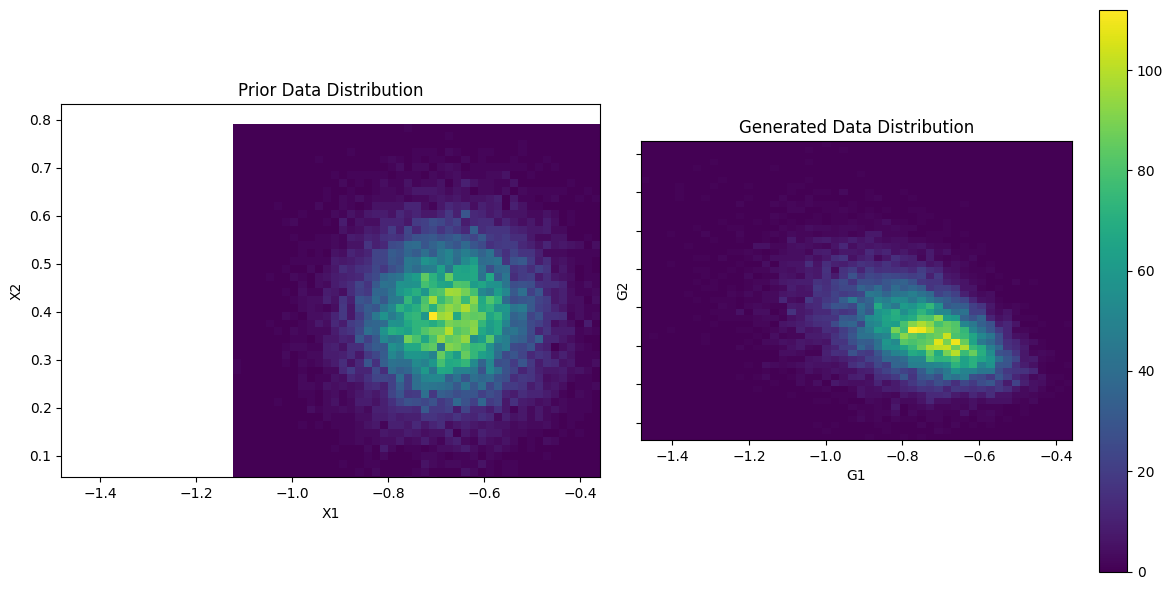

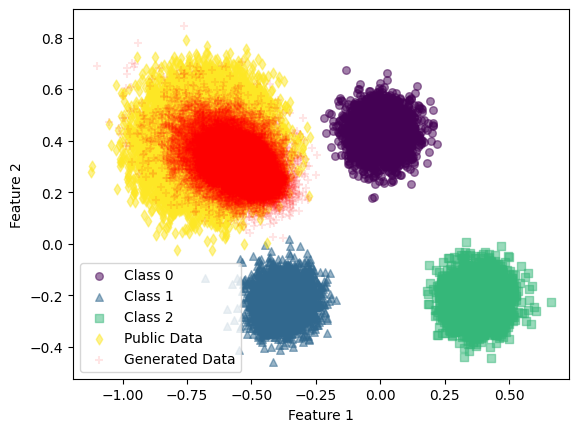

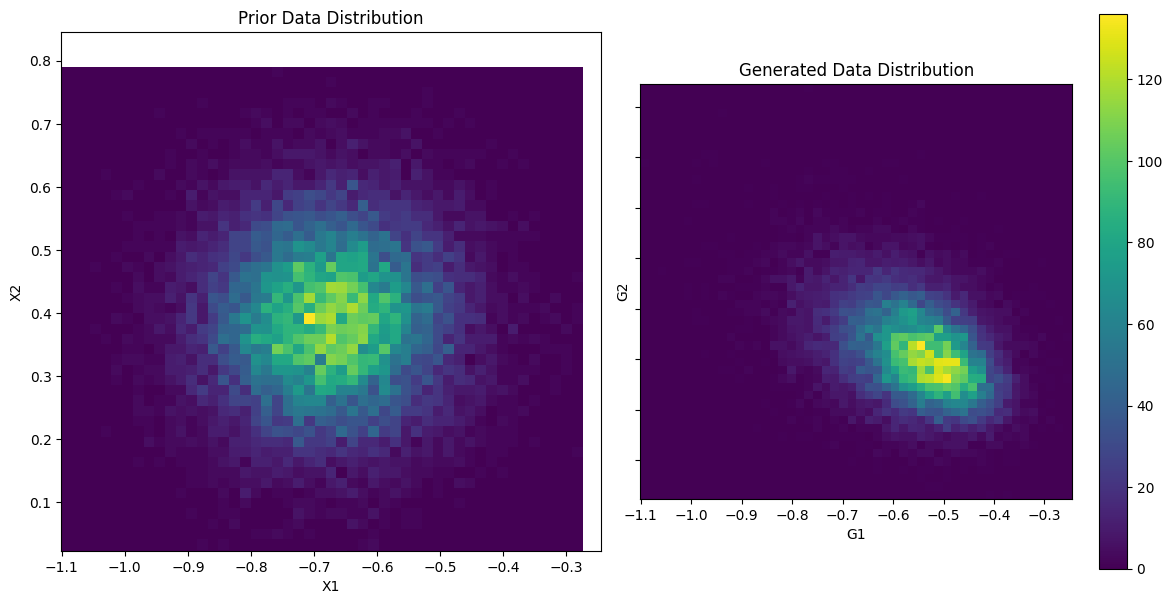

In [23]:
def WGAN_GP_Train(opt, dataset):
    dataset = dataset.numpy()
    train_dataloader = DataLoader(dataset, batch_size=public_batch_size, shuffle=True)
    z_fix = torch.randn(len(train_dataloader.dataset), opt.z_dim, device=device)
    model = WGAN_GP(data_dim=opt.data_dim, hidden_dim=opt.hidden_dim, z_dim=opt.z_dim, lambda_gp=opt.lambda_gp, device=device)
    model.to(device)
    optimizer_G, optimizer_D = model.get_optimizer(opt.lr, opt.b1, opt.b2)

    for epoch in range(1, opt.max_epoch+1):
        model.train()

        for batch_data in train_dataloader:
            for _ in range(5):
                real_data = batch_data.to(device)
                z = torch.randn(len(batch_data), opt.z_dim, device=device)
                batch_D_loss = model.calculate_D_loss(z, real_data)
                optimizer_D.zero_grad()
                batch_D_loss.backward()
                optimizer_D.step()

            z = torch.randn(opt.batch_size, opt.z_dim, device=device)
            batch_G_loss = model.calculate_G_loss(z)
            optimizer_G.zero_grad()
            batch_G_loss.backward()
            optimizer_G.step()

        if (epoch+1) % opt.verbose == 0:
            for i, label in enumerate(unique_labels[:-1]):  
                idx = final_labels == label
                plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[i]], label=f'Class {label}', marker=markers[i % len(markers)], s=scatter_size, alpha=0.5)

            idx = final_labels == unique_labels[-1]
            plt.scatter(dataset[:, 0], dataset[:, 1], c=[colors[-1]], label='Public Data', marker=markers[-1], s=scatter_size, alpha=0.5)

            with torch.no_grad():
                xpred = model.G(z_fix)  

            generated_data_np = xpred.cpu().numpy()
            plt.scatter(generated_data_np[:, 0], generated_data_np[:, 1], c='red', label='Generated Data', marker=markers[-2], s=scatter_size, alpha=0.1)

            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
            plt.legend()
            plt.axis('equal')
            plt.show()

        if (epoch+1) % opt.verbose == 0:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
            
            axes[0].hist2d(dataset[:, 0], dataset[:, 1], bins=50, cmap='viridis')
            axes[0].set_title('Prior Data Distribution')
            axes[0].set_xlabel('X1')
            axes[0].set_ylabel('X2')
            
            axes[1].hist2d(generated_data_np[:, 0], generated_data_np[:, 1], bins=50, cmap='viridis')
            axes[1].set_title('Generated Data Distribution')
            axes[1].set_xlabel('G1')
            axes[1].set_ylabel('G2')
            
            axes[0].set_aspect('equal')
            axes[1].set_aspect('equal')

            plt.colorbar(axes[1].hist2d(generated_data_np[:, 0], generated_data_np[:, 1], bins=50, cmap='viridis')[3], ax=axes[1])
            
            plt.tight_layout()
            plt.show()
    
    return model

opt = WGAN_GP_Config()
model = WGAN_GP_Train(opt, public_data_normal)

### Examine randomly generated points (ensure the generator fit the public data well, in order to achieve a good MI performance)

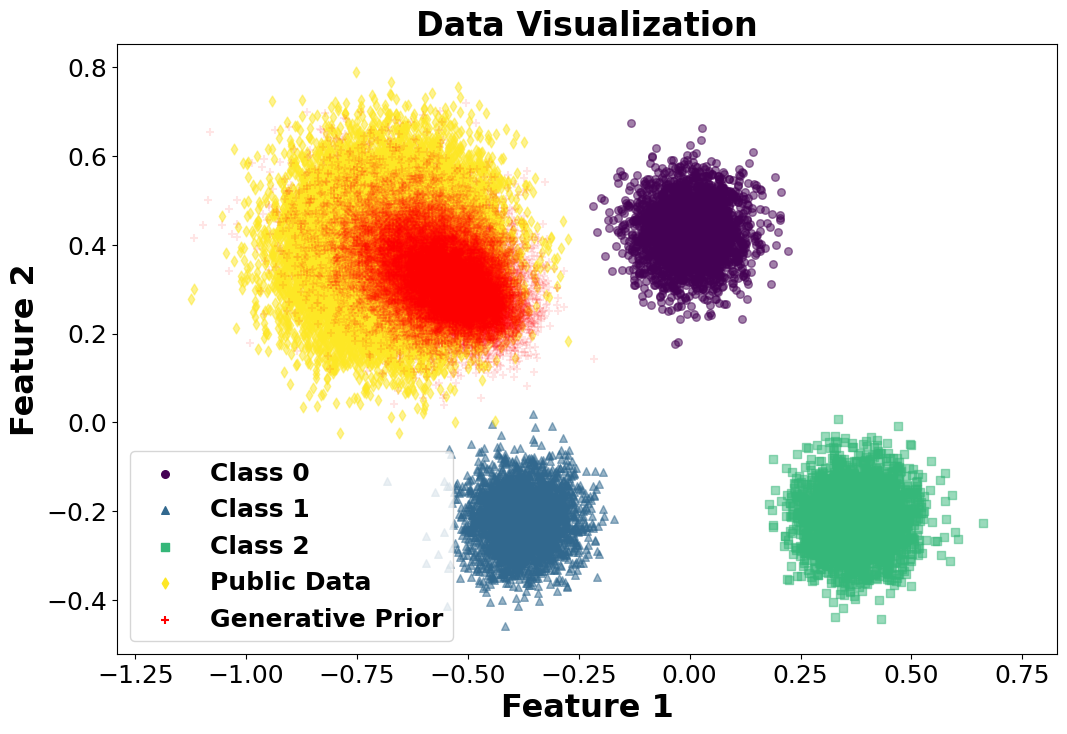

In [24]:
model.G.eval()
z_fix = torch.randn(public_data.shape[0], opt.z_dim, device=device)

plt.figure(figsize=(10.5, 7))
for i, label in enumerate(unique_labels[:-1]):  
    idx = final_labels == label
    plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[i]], label=f'Class {label}', marker=markers[i % len(markers)], s=scatter_size, alpha=0.5)

idx = final_labels == unique_labels[-1]
plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[-1]], label='Public Data', marker=markers[-1], s=scatter_size, alpha=0.5)

with torch.no_grad():
    xpred = model.G(z_fix)  

generated_data_np = xpred.cpu().numpy()
plt.scatter(generated_data_np[:, 0], generated_data_np[:, 1], c='red', label='Generative Prior', marker=markers[-2], s=scatter_size, alpha=0.1)

plt.xlabel('Feature 1', fontsize=23, fontweight='bold')
plt.ylabel('Feature 2', fontsize=23, fontweight='bold')
plt.axis('equal')
legend_properties = {'weight':'bold', 'size':18}
legend = plt.legend(loc='lower left', prop=legend_properties)
for lh in legend.legendHandles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.axis('equal')
plt.tick_params(axis='both', which='major', labelsize=18)

title = "Data Visualization"
plt.title(title, fontsize=24, fontweight='bold')
plt.savefig(f'./results/toy_data_visualization.png') 

### Model inversion attack function

In [25]:
import os
import imageio
import shutil
import torch.nn.functional as F
import torch


def mi_attack(G, target_label, target_model, num_epochs=500, title=""):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.eval()

    criterion = nn.NLLLoss()
    batch_size = 1000
    z = nn.Parameter(torch.randn(batch_size, opt.z_dim).to(device), requires_grad=True) 
    optimizer = optim.Adam([z], lr=0.01)

    target_labels = torch.ones(batch_size, dtype=torch.long, device=device) * target_label
    target_model = target_model.to(device)

    num_epochs = num_epochs
    for epoch in range(num_epochs):
        generated_data = G(z)  
        predictions = target_model(generated_data)  
        loss = criterion(predictions, target_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:  
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
            inv_data_np = generated_data.cpu().detach().numpy().squeeze()  
            predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
            true_labels = target_labels.cpu().numpy()

            correct_mask = (predicted_labels == true_labels)
            
            correct_data = inv_data_np[correct_mask]
            incorrect_data = inv_data_np[~correct_mask]

            plt.figure(figsize=(10.5, 7))
            clear_output(wait=True)

            for i, label in enumerate(unique_labels[:-1]):  
                idx = final_labels == label
                plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[i]], label=f'Class {label}', marker=markers[i % len(markers)], s=scatter_size, alpha=0.1)

            idx = final_labels == unique_labels[-1]
            plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[-1]], label='Public Data', marker=markers[-1], s=scatter_size, alpha=0.5)

            plt.xlabel('Feature 1', fontsize=23, fontweight='bold')
            plt.ylabel('Feature 2', fontsize=23, fontweight='bold')

            plt.scatter(inv_data_np[:, 0], inv_data_np[:, 1], alpha=0.5, marker='o', color='red', label='Inverse Data')

            legend_properties = {'weight':'bold', 'size':18}
            legend = plt.legend(loc='lower left', prop=legend_properties)
            for lh in legend.legendHandles: 
                lh.set_alpha(1)
            
            plt.tight_layout()
            plt.axis('equal')
            plt.tick_params(axis='both', which='major', labelsize=18)
            
            plt.title(title, fontsize=24, fontweight='bold')

            base_dir = f'./{title}'
            if not os.path.exists(base_dir):
                os.makedirs(base_dir)

            plt.savefig(os.path.join(base_dir, f'image{epoch+1}.png'), bbox_inches='tight')
            if (epoch + 1) == num_epochs:
                plt.savefig(os.path.join(base_dir, f'image{epoch+1}.pdf'), bbox_inches='tight')

            plt.show()

    images = []
    file_names = sorted([fn for fn in os.listdir(base_dir) if fn.endswith('.png')], key=lambda x: int(x.replace('image', '').replace('.png', '')))
    for filename in file_names:
        images.append(imageio.imread(os.path.join(base_dir, filename)))
    imageio.mimsave(f'./gif/{title}.gif', images, duration=0.2, loop=1)  
    
    centers = np.array(list(zip(np.array(gap_list)/positive_limit, np.array(y_center)/positive_limit)))
    with torch.no_grad():
        distances = torch.sqrt(((generated_data - torch.tensor(centers[target_label], device=generated_data.device)) ** 2).sum(1))
        average_distance = distances.mean().item()
        print(f"Average distance to Gaussian centers: {average_distance:.2f}")

    with torch.no_grad():
        target_center = torch.tensor(centers[target_label], device=generated_data.device).unsqueeze(0)
        distances = torch.sqrt(((generated_data - target_center) ** 2).sum(dim=1))
        min_distance = distances.min().item()
        print(f"Minimum distance to Gaussian center: {min_distance:.2f}")

    with torch.no_grad():
        sigma = np.sqrt(variance)  

        target_center_tensor = torch.tensor(centers[target_label], device=device)
        distances = torch.sqrt(((torch.tensor(inv_data_np).to(device) - target_center_tensor) ** 2).sum(dim=1))
        three_sigma_range = 3 * sigma / positive_limit
        within_three_sigma = (distances <= three_sigma_range).sum().item()
        attack_acc = within_three_sigma / len(inv_data_np)
        print(f'Attack Accuracy (within 3 sigma): {attack_acc:.2%}')

    return correct_data

### Conditional Transport function

In [26]:
def init_weights(m):
    if type(m) == nn.Linear:
        gain = nn.init.calculate_gain('leaky_relu', 0.01)
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(0.01)


class Projector(torch.nn.Module):
    def __init__(self, D_in, H, D_out=1):
        super(Projector, self).__init__()
        self.model = nn.Sequential(nn.Linear(D_in, H),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H),
                                   nn.Linear(H, H//2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(H//2),
                                   nn.Linear(H//2, D_out)
                                  )
        self.model.apply(init_weights)
        
    def forward(self, x):
        logit = self.model(x)
        return logit


def conditional_OT(G, P, pp_data, epochs=500, title=""):
    g_opt = optim.Adam(G.parameters(), lr=1e-2)
    p_opt = optim.Adam(P.parameters(), lr=1e-2)

    pp_data = torch.from_numpy(pp_data).to(device) 
    z_align = torch.randn(pp_data.size(0), opt.z_dim).to(device) 

    rho = 0.5
    print_freq = 10
    for epoch in range(epochs+1):
        p_loss = 0
        g_loss = 0

        xpred = G(z_align)
        X = pp_data 
        N = X.size(0)

        X_ = X.repeat(N,1,1).transpose(0,1) 
        xpred_ = xpred.repeat(N,1,1) 

        diff = torch.nn.functional.mse_loss(X_, xpred_, reduction='none') 
        cost = diff.sum(-1) 
        tmp_x = P(X).repeat(N,1,1).transpose(0, 1) 
        tmp_fake = P(xpred).repeat(N,1,1) 

        weight_x = torch.nn.functional.softmax(-torch.norm(tmp_x - tmp_fake, dim=-1), dim=0) 
        weight_xpred = torch.nn.functional.softmax(-torch.norm(tmp_x - tmp_fake, dim=-1), dim=1) 

        g_opt.zero_grad()
        p_opt.zero_grad()
        gloss = (cost * weight_xpred).sum(1).mean()
        ploss = (cost * weight_x).sum(0).mean()
        loss = rho * gloss + (1-rho) * ploss
        loss.backward()
        g_opt.step()
        p_opt.step()
        g_loss += gloss.item()
        p_loss += ploss.item()

        if (epoch+1) % print_freq == 0:
            with torch.no_grad():
                xpred = G(z_align)
            
            plt.figure(figsize=(10.5, 7))
            clear_output(wait=True)

            for i, label in enumerate(unique_labels[:-1]):  
                idx = final_labels == label
                plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[i]], label=f'Class {label}', marker=markers[i % len(markers)], s=scatter_size, alpha=0.1)

            idx = final_labels == unique_labels[-1]
            plt.scatter(final_inputs[idx, 0], final_inputs[idx, 1], c=[colors[-1]], label='Public Data', marker=markers[-1], s=scatter_size, alpha=0.5)

            plt.xlabel('Feature 1', fontsize=23, fontweight='bold')
            plt.ylabel('Feature 2', fontsize=23, fontweight='bold')
        
            generated_data_align = xpred.cpu().detach().numpy()
            correct_data = pp_data.cpu().detach().numpy()
            plt.scatter(correct_data[:, 0], correct_data[:, 1], alpha=1.0, marker='o', color='red', label='Inverse Data')
            plt.scatter(generated_data_align[:, 0], generated_data_align[:, 1], alpha=1.0, marker='x', color='blue', label='Tuned Prior')
            
            legend_properties = {'weight':'bold', 'size':18}
            legend = plt.legend(loc='lower left', prop=legend_properties)
            for lh in legend.legendHandles: 
                lh.set_alpha(1)

            plt.xlim(left=-1.25, right=0.75)  
            
            plt.tight_layout()
            plt.axis('equal')
            plt.tick_params(axis='both', which='major', labelsize=18)
            plt.title(title, fontsize=24, fontweight='bold')

            base_dir = f'./{title}'
            if not os.path.exists(base_dir):
                os.makedirs(base_dir)

            plt.savefig(os.path.join(base_dir, f'image{epoch+1}.png'), bbox_inches='tight')
            if (epoch + 1) == epochs:
                plt.savefig(os.path.join(base_dir, f'image{epoch+1}.pdf'), bbox_inches='tight')

            plt.show()
            print("Epoch {}/{}: \t ploss {}  \t gloss {} \t loss {} ".format(epoch+1, epochs, p_loss/(epoch+1), g_loss/(epoch+1), (p_loss/(epoch+1)+g_loss/(epoch+1))/2))


    images = []
    file_names = sorted([fn for fn in os.listdir(base_dir) if fn.endswith('.png')], key=lambda x: int(x.replace('image', '').replace('.png', '')))
    for filename in file_names:
        images.append(imageio.imread(os.path.join(base_dir, filename)))
    imageio.mimsave(f'./gif/{title}.gif', images, duration=0.2, loop=1)  

    return G

### Baseline

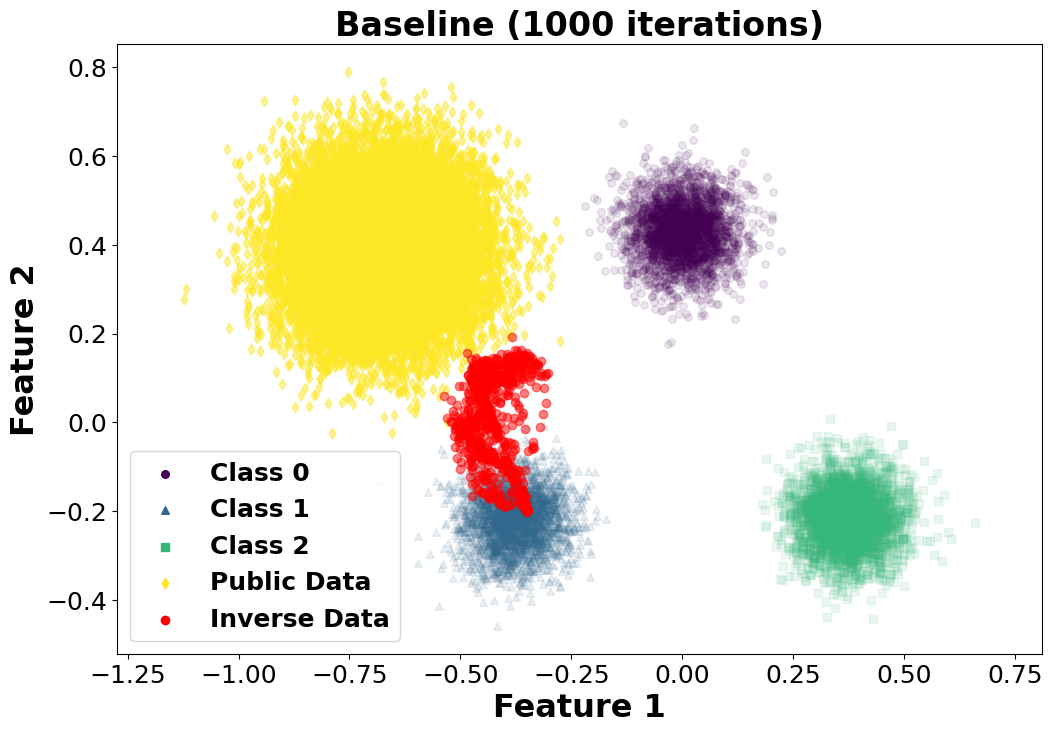

/home/csxpeng/anaconda3/envs/mia/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Average distance to Gaussian centers: 0.22
Minimum distance to Gaussian center: 0.03
Attack Accuracy (within 3 sigma): 33.10%


In [27]:
target_label = 1
num_epochs = 1000
pp_data = mi_attack(G=model.G, 
          target_label=target_label, 
          target_model=model_vanilia,
          num_epochs=num_epochs,
          title="Baseline (1000 iterations)")

### Iterative Adjustment of G

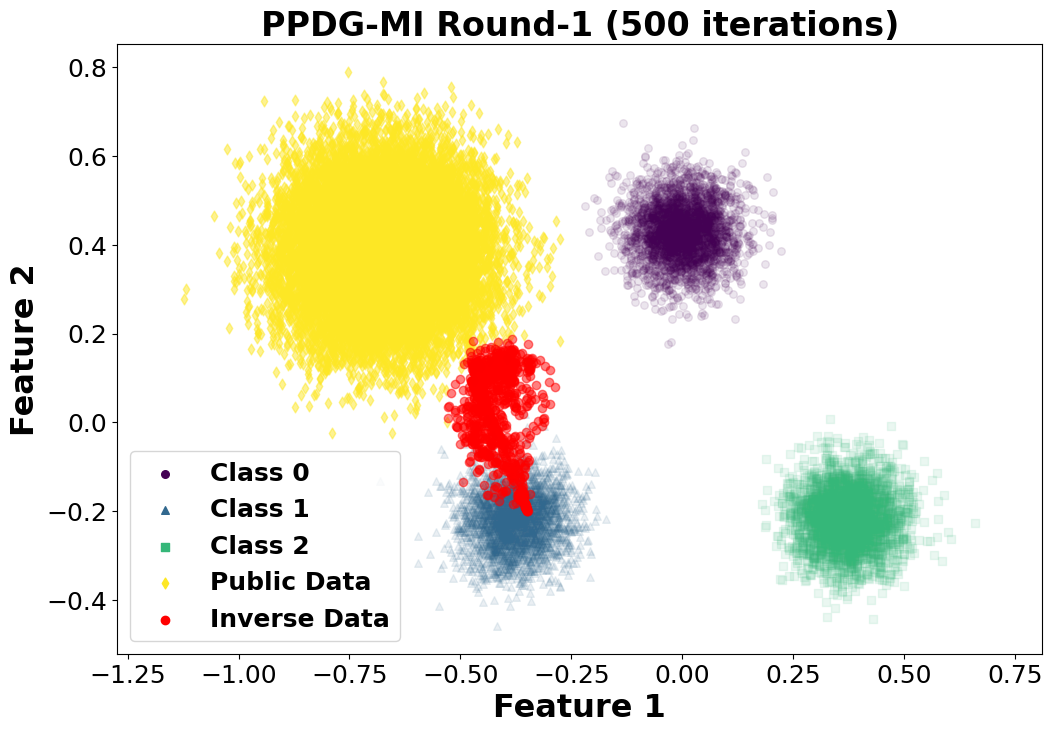

/home/csxpeng/anaconda3/envs/mia/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Average distance to Gaussian centers: 0.25
Minimum distance to Gaussian center: 0.03
Attack Accuracy (within 3 sigma): 22.70%


In [28]:
target_label = 1
num_epochs = 500
pp_data = mi_attack(G=model.G, 
          target_label=target_label, 
          target_model=model_vanilia,
          num_epochs=num_epochs,
          title="PPDG-MI Round-1 (500 iterations)")

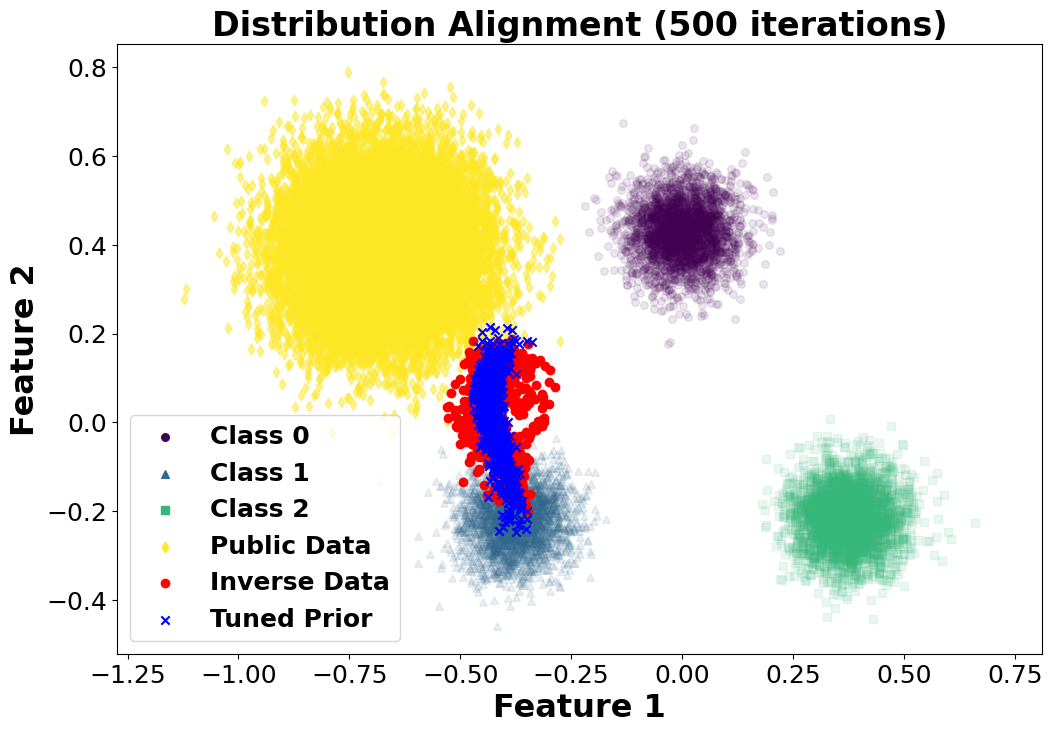

Epoch 500/500: 	 ploss 4.420327488332987e-06  	 gloss 4.428944550454616e-06 	 loss 4.424636019393802e-06 


/home/csxpeng/anaconda3/envs/mia/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [29]:
import copy

G = copy.deepcopy(model.G)
P = Projector(D_in=2, H=100, D_out=1).to(device)
new_G = conditional_OT(G=G, P=P, pp_data=pp_data, epochs=500,
                       title="Distribution Alignment (500 iterations)")

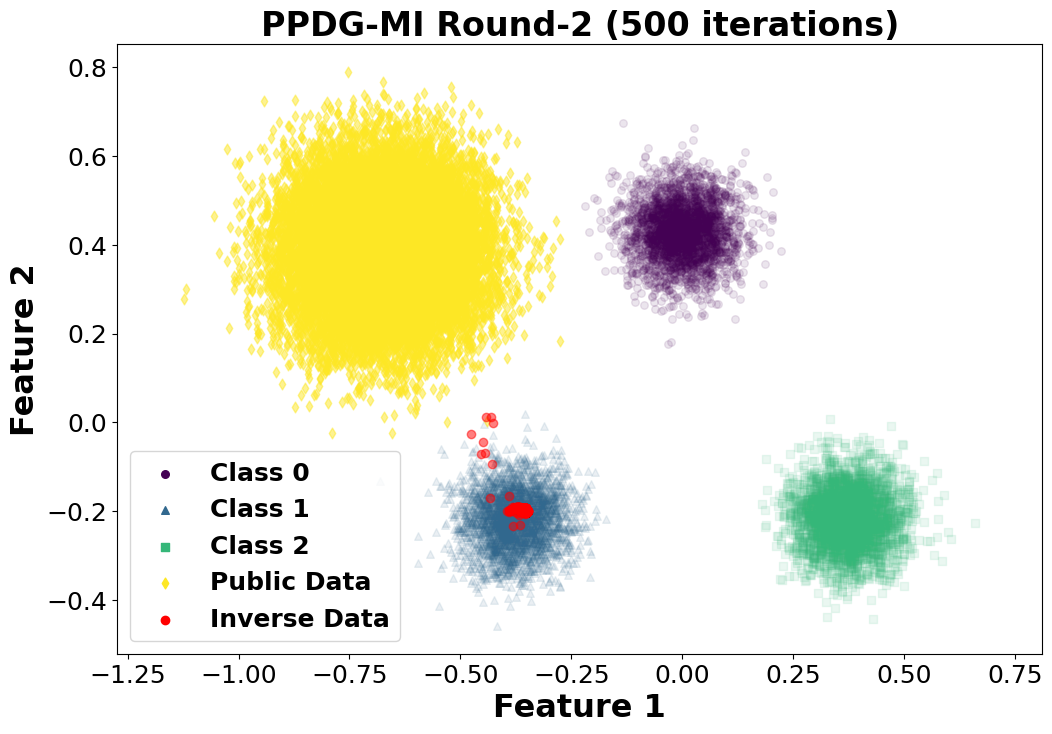

/home/csxpeng/anaconda3/envs/mia/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Average distance to Gaussian centers: 0.03
Minimum distance to Gaussian center: 0.01
Attack Accuracy (within 3 sigma): 99.60%


In [30]:
target_label = 1
num_epochs = 500
pp_data = mi_attack(G=new_G, 
          target_label=target_label, 
          target_model=model_vanilia,
          num_epochs=num_epochs,
          title="PPDG-MI Round-2 (500 iterations)")